<a href="https://colab.research.google.com/github/JSJeong-me/KSIA/blob/master/12-15-ResNet_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Flowers Classification


Dataset [here](https://public.roboflow.ai/classification/flowers)



## Intro

### About Fastai
If you haven't heard of `Fastai` yet I recommend taking a look at their [homepage](https://www.fast.ai/). In their mission statement it is stated that not only do they want to accelerate and help deep learning research, they also want to decrease the entry barriers for everyone. This line is from their introduction of `PyTorch` for `Fastai` back in September 2017 [(Source)](https://www.fast.ai/2017/09/08/introducing-pytorch-for-fastai/):

    Everybody should be able to use deep learning to solve their problems with no more education than it takes to use a smart phone. Therefore, each year our main research goal is to be able to teach a wider range of deep learning applications, that run faster, and are more accurate, to people with less prerequisites.

You can feel this ambition even if you watch `Fastai`'s 2019 course, and it's something that gives me a good feeling about the direction the field is headed. As it often happens in research, knowledge and tools are only accessible to a certain minority. This is even more pronounced in deep learning research, where you need huge amounts of RAM in powerful GPUs to solve a lot of problems (check this unrelated [video](https://www.youtube.com/watch?v=-P28LKWTzrI) on GPU vs CPU).

### Setting up Google Colab
To avoid redundancy online, please check this [Medium post](https://towardsdatascience.com/fast-ai-lesson-1-on-google-colab-free-gpu-d2af89f53604) by [Manikanta Yadunanda](https://towardsdatascience.com/@manikantayadunanda) for a quick introduction on how to use the Google Colaboratory (Colab) with `Fastai`. Since this introduction was written, Google has included official `Fastai` and `PyTorch` support in Colab. You can check with the following line of code if all of the important `pip` packages are installed. If not, uncomment the last line and use it to install `Fastai` and `PyTorch` for Python 3.6.x and CUDA 9.x.

In [ ]:
# Check if fastai and pytorch are installed
!pip list | grep -e fastai -e torch -e torchvision

fastai                   1.0.61         
torch                    1.5.0+cu101    
torchsummary             1.5.1          
torchtext                0.3.1          
torchvision              0.6.0+cu101    


In [ ]:
# If not, uncomment this line and run to install them
#!pip install torch torchvision fastai

### Cloning this Notebook
To access this notebook and run the computations yourself, you can simply import it directly from my GitHub repository. Just go to File... Open Notebook..., select the GitHub tab and enter 'verrannt/Tutorials' in the search bar. Select the 'fastai-plant-seedlings-classification.ipynb' and you're done. Simple as that. After you checked that Colab is configured for `Fastai` support, you can continue with the data preperation part.

## Data Preperation

### Get the Data

We'll grab our data from Roboflow.

Select `Export`, and "Show Download Code".

In [ ]:
# YOUR DOWNLOAD LINK HERE

### Inspect the Data
Let's inspect the data. The folder we downloaded and extracted from Kaggle has 12 subfolders, each of which corresponds to one type of seedling with its respective images inside. These will be our labels for the classification task.

If we print the lengths of the contents of these folders we can see that every folder contains a different amount of images. The differences are great, see e.g. that the 'Loose Silky-bent' has the most images (762) while the 'Common Wheat' the fewest (253). We will see later if this amounts to differences in the prediction accuracy.

In [ ]:
import os
labels = os.listdir("train")
print("No. of labels: {}".format(len(labels)))
print("-----------------")

for label in labels:
    print("{}, {} files".format(label, len(os.listdir("train/"+label))))

No. of labels: 2
-----------------
dandelion, 1052 files
daisy, 769 files


Let's have a look at those images. For each of the 12 labels, we will print one random seedling.

IndexError: ignored

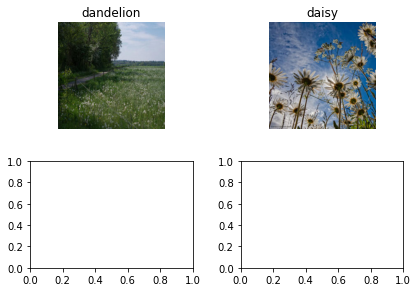

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.tight_layout()
cnt = 0
for row in ax:
    for col in row:
        image_name = np.random.choice(os.listdir("train/" + labels[cnt]))
        im = Image.open("train/{}/{}".format(labels[cnt],image_name))
        col.imshow(im)
        col.set_title(labels[cnt])
        col.axis('off')
        cnt += 1
plt.show()

Alright, they look good with a wide array of images!

## Creating the Fastai Model


We can now create the CNN model using the `Fastai` library. Since its major update to v1, it got a lot clearer and consistent, so we only need to import the vision module and accuracy for our metric.

In [ ]:
from fastai.vision import *
from fastai.metrics import accuracy

`Fastai` has a really nice class for handling everything related to the input images for vision tasks. It is called [`ImageDataBunch`](https://docs.fast.ai/vision.data.html#ImageDataBunch) and has different functions, respective of the different ways data can be presented to the network. Since our images are placed in folders whose names correspond to the image labels, we will use the `ImageDataBunch.from_folder()` function to create an object that contains our image data. This is super useful and makes it incredibly easy to read the data into our model, as you will see in a bit. 

What's even more handy is that `Fastai` can automatically split our data into train and validation sets, so we don't even need to create these on our own.

The only hyperparameters we need now are the **path-variable** pointing to our data set, the **size of the inputs** and the **batch size** for each gradient descent iteration. To make matters simple, the `ImageDataBunch` object will scale all images to a size*size squared image unless otherwise instructed.

A quick note on image size: the bigger an image, the more details the CNN will be able to pick out of it. At the same time, a bigger image means longer computation times. On the same note it might be that your GPU runs out of memory for a too large batch size. You can half the batch size if this is the case.



In [ ]:
path = "./train/"
size = 224
bs = 64

We will create a variable called `data` in which we place the `ImageDataBunch` object. We create this object with the `from_folder()` function that we discussed above. Among the path to our data, the image and batch size, it also takes:
* a function argument called `get_transforms()` which returns a list of available image transformations upon call.
* a parameter `valid_pct` which controls the percentage of images that will be randomly chosen to be in the validation set
* a parameter `flip_vert` which controls vertical flips and 90° turns in addition to just horizontal flips. (Since our plant images are taken from above, we can perform those without a problem, which would not be feasible on e.g. face data.)

In [ ]:
data = ImageDataBunch.from_folder(path,
                                  valid_pct=0.2, size=size, bs=bs)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

In [ ]:
# data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(do_flip=True, flip_vert=True),
 #                                 valid_pct=0.2, size=size, bs=bs)

To normalize the data in our object, we simply call `normalize()` on the object. It is possible to use ImageNet, CIFAR or MNIST stats as templates here, and if left empty this function will simply grab a batch of data from our object and compute the stats on it (mean and standard-deviation) and normalize the data accordingly. Since we will be using a ResNet architecture for our model which was trained on ImageNet, we will be using the ImageNet stats.

In [ ]:
data.normalize(imagenet_stats)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

ImageDataBunch;

Train: LabelList (1457 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
dandelion,dandelion,dandelion,dandelion,dandelion
Path: train;

Valid: LabelList (364 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
dandelion,dandelion,daisy,dandelion,daisy
Path: train;

Test: None

That's it, two lines of code for optimizing our dataset for training, adding different kinds of transformations and normalization! I would kindly ask you to stop here for a moment and just take a second to appreciate the beauty of this. The beauty of high-level libraries; just two lines of code and we have increased the diversity of our dataset tremendously. I can already hear my ugly batchnorm code crying in the trashbin.

All that is left now is to create the actual network and train it, which could not be more simple.

`Fastai` supplies us with a function called [`create_cnn()`](https://docs.fast.ai/vision.learner.html#create_cnn) from its vision module. This function creates what is called a `learner` object, which we'll put into a properly named variable. See here that we specify the ResNet architecture as our base model for transfer learning. Upon call, the trained architecture will be downloaded via the `Fastai` API and stored locally.

We will use accuracy for our metric. If you check the [docs](https://docs.fast.ai/metrics.html) you can see a list of other metrics which are availabe. Defining the callback function `ShowGraph` simply tells the learner that it should return a graph for whatever it does, which seems very useful to me for seeing whether the model is still improving. 

In [ ]:
learner = cnn_learner(data, models.resnet18, metrics=[accuracy], callback_fns=ShowGraph)

### Finding the learning rate

The learner object we create comes with a build-in function to find the optimal learning rate, or range of learning rates, for training. It achieves this by fitting the model for a few epochs and saving for which learning rates the loss decreases the most.

We want to choose a learning rate, for which the loss is still decreasing, i.e. we do not want the learning rate with the minimum loss, but with the steepest slope. 

In the following plot, which is stored in the recorder object of our learner, we can see that this is the case for learning rates between 0.001 and 0.01.

In [ ]:
learner.lr_find()
learner.recorder.plot()

Streaming output truncated to the last 5000 lines.
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old beha

### First fit and evaluation
Now let's fit our model for 8 epochs, with a learning rate between 0.001 and 0.01

In [ ]:
learner.fit_one_cycle(8, max_lr=slice(1e-3, 1e-2))

That already looks good! The loss is decreasing a lot in the first few 1/5th of iterations, and less but continously afterwards. 

Let's see where the algorithm is making the most mistakes:

In [ ]:
interpreter = ClassificationInterpretation.from_learner(learner)

In [ ]:
interpreter.most_confused(min_val=2)

[('Black-grass', 'Loose Silky-bent', 28),
 ('Loose Silky-bent', 'Black-grass', 7),
 ('Shepherd’s Purse', 'Scentless Mayweed', 4)]

This shows us that the algorithm confuses a few of our class examples, but it's doing well, overall.

## Improving the Model

### Unfreezing and fine-tuning
Before we unfreeze the layers and learn again, we save the weights so we can go back in case we mess up.

In [ ]:
learner.save('stage-1')
#learner.load('stage-1')

In [ ]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy
1,0.185980,0.147381,0.948510
2,0.192799,0.169766,0.937669
3,0.193751,0.135442,0.949413
4,0.174922,0.121518,0.959350
5,0.141505,0.115559,0.957543
6,0.113001,0.103410,0.963866
7,0.093303,0.098421,0.967480
8,0.088163,0.095546,0.965673


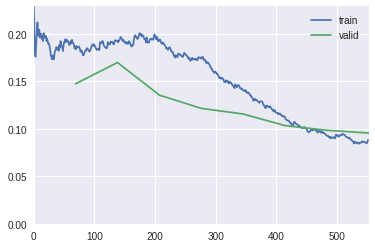

In [ ]:
learner.fit_one_cycle(12, max_lr=slice(1e-5, 1e-4))

We will stick to this, because the validation error is getting worse than the testing error, and it looks like this tendency will only increase. The model would start to **overfit the training data** if we continue training from this point onwards! 

Good job, we successfully trained a state-of-the-art image classifier for a custom dataset, achieving 96.5% accuracy in just a handful of lines of code!